In [1]:
%pylab inline  

import pandas as pd
import re
import string
import operator

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

import sentencepiece as spm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('nosleep.csv')

# Some posts were deleted
df = df[df.Author != '[deleted]']

# Some text is empty
df = df[df.Text.isna() == False]

# Some text is too short
df = df[df.Text.str.len() > 100]

In [28]:
%%time

def get_sentences_from_story(story):
    # A story is broken up into markdown paragraphs
    paragraphs = list(filter(lambda x: len(x) > 0, story.split("\n")))
    all_sentences = []
    
    for this_paragraph in paragraphs:
        # If the paragram markdown contains a link, remove it
        if "[" in this_paragraph and 'https://' in this_paragraph:
            continue

        # Remove special symbols
        if this_paragraph.startswith("&amp;"):
            continue
        
        #Split paragraph into sentences based on end-of-sentence punctuation
        paragram_sentences = re.split("[.!?]", this_paragraph)
        for this_sentence in paragram_sentences:
            
            # Remove punctuation symbols
            for char in string.punctuation + "’”“…—-":
                this_sentence = this_sentence.replace(char, ' ')
                
            # Remove multiple whitespace
            this_sentence = re.sub("\s{2,}", " ", this_sentence)
                
            # Remove initial and trailing whitespace, and make everything lowercase
            this_sentence = this_sentence.strip().lower()
            
            # Replace numbers with a special <NUM> token
            this_sentence = re.sub("\d+", "<NUM>", this_sentence)    
            
            if len(this_sentence) > 0:
                all_sentences.append(this_sentence)
      
    return all_sentences


stories_none = {}
stories_series = {}

NUM_STORIES = 1000

for index, this_story in df[df.Flair == 'None'][:NUM_STORIES].iterrows():
    stories_none[index] = get_sentences_from_story(this_story.Text)
    
for index, this_story in df[df.Flair == 'Series'][:NUM_STORIES].iterrows():
    stories_series[index] = get_sentences_from_story(this_story.Text)
        

CPU times: user 5.36 s, sys: 126 ms, total: 5.49 s
Wall time: 5.41 s


In [29]:
%%time 
sentence_counts = []
word_counts = []

all_stories = list(stories_none.values()) + list(stories_series.values())
for story in all_stories:
    sentence_counts.append(len(story))
    for this_sentence in story:
        word_counts.append(len(this_sentence.split(' ')))

CPU times: user 316 ms, sys: 11.3 ms, total: 328 ms
Wall time: 321 ms


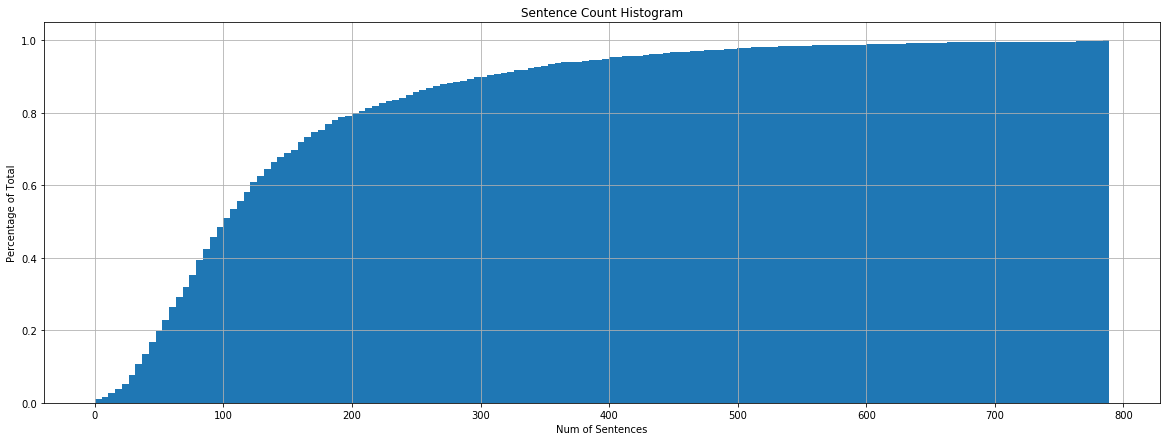

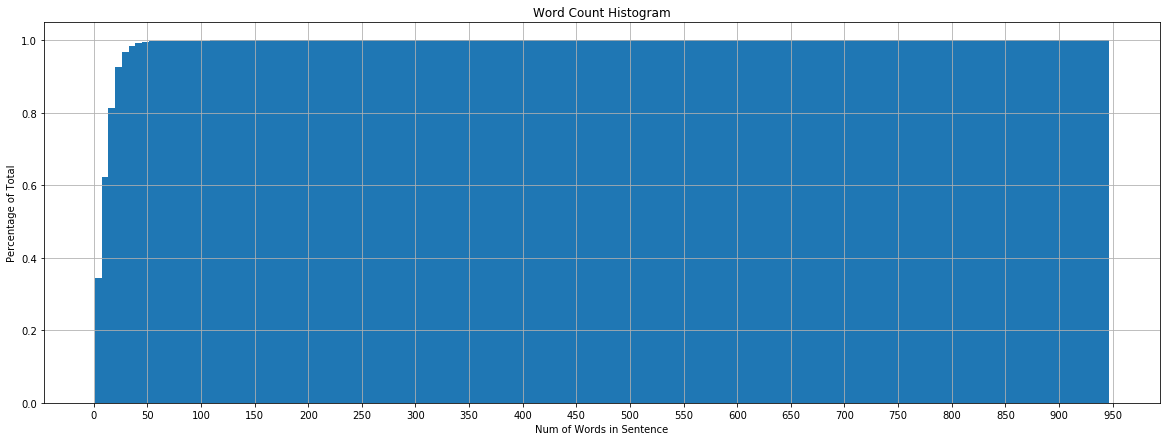

In [30]:
figure(figsize=(20,7))
hist(sentence_counts, bins=150, cumulative=True, density=True)
grid(axis='both')
title("Sentence Count Histogram")
xlabel('Num of Sentences')
ylabel('Percentage of Total');

figure(figsize=(20,7))
hist(word_counts, bins=150, cumulative=True, density=True)
grid(axis='both')
xticks(arange(0,1000,50));
title("Word Count Histogram")
xlabel('Num of Words in Sentence')
ylabel('Percentage of Total');

In [31]:
VOCAB_SIZE=500

# Prepare all sentence in a single text file
with open('all_sentences.txt','w') as f:
    for story in all_stories:
        for sentence in story:
            f.write(sentence + "\n")
            
spm.SentencePieceTrainer.Train('--input=all_sentences.txt --model_prefix=stories --vocab_size={}'.format(500))

True

In [32]:
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load('stories.model')

True

In [33]:
text = choice(choice(all_stories))

print(text)
print(tokenizer.encode_as_pieces(text))
print(tokenizer.encode_as_ids(text))



i will right another entry of discovery as time permits
['▁i', '▁will', '▁right', '▁another', '▁', 'ent', 'ry', '▁of', '▁dis', 'c', 'o', 'ver', 'y', '▁as', '▁time', '▁p', 'er', 'm', 'it', 's']
[5, 292, 289, 395, 16, 111, 191, 19, 302, 26, 27, 166, 21, 53, 151, 42, 31, 30, 59, 3]


In [50]:
%%time


MAX_SENTENCES = 15
MAX_WORDS = 60

def convert_to_matrix(stories, max_sentences= MAX_SENTENCES, max_words = MAX_WORDS):
    token_matrix = np.zeros((len(stories), max_sentences, max_words), dtype=np.int32)
    story_index = 0

    for sentence_list in list(stories.values()):
        sentence_index = len(sentence_list)
        matrix_index = max_sentences
        while sentence_index > 0 and matrix_index > 0:
            sentence_tokens = tokenizer.encode_as_ids(sentence_list[sentence_index-1])
   
            if len(sentence_tokens) > MAX_WORDS:
                sentence_tokens = sentence_tokens[:MAX_WORDS]
                
            
            for i in range(len(sentence_tokens)):
                token_matrix[story_index, matrix_index - 1, i] = sentence_tokens[i]    
        
            matrix_index -= 1
            sentence_index -= 1
        
        story_index += 1  
        
    
    return token_matrix


tokens_none = convert_to_matrix(stories_none)
tokens_series = convert_to_matrix(stories_series)

CPU times: user 1.68 s, sys: 26.7 ms, total: 1.71 s
Wall time: 1.69 s


In [51]:
X = np.concatenate((tokens_none, tokens_series), axis=0)
y = np.concatenate((np.repeat(0, NUM_STORIES), np.repeat(1, NUM_STORIES)))

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1600, 15, 60), (1600,), (400, 15, 60), (400,))

In [52]:
EMBEDDING_SIZE = 150
HIDDEN_SIZE=512

class HierarchicalAttentionNetwork(nn.Module):
    def __init__(self, **kwargs):
        super(HierarchicalAttentionNetwork, self).__init__(**kwargs)
        self.embeddings = nn.Embedding(VOCAB_SIZE, EMBEDDING_SIZE)
        
        self.word_gru = nn.GRU(EMBEDDING_SIZE, HIDDEN_SIZE, batch_first=True, bidirectional=True)
        self.word_projection = nn.Linear(2*HIDDEN_SIZE, 2*HIDDEN_SIZE)
        self.word_vector = nn.Parameter(torch.randn(1,2*HIDDEN_SIZE)).repeat(MAX_WORDS,1).cuda()
        
        self.sentence_gru = nn.GRU(2*HIDDEN_SIZE, HIDDEN_SIZE, batch_first=True, bidirectional=True)
        self.sentence_projection = nn.Linear(2*HIDDEN_SIZE, 2*HIDDEN_SIZE)
        self.sentence_vector = nn.Parameter(torch.randn(1,2*HIDDEN_SIZE).repeat(MAX_SENTENCES, 1)).cuda()
        
        self.fc1 = nn.Linear(2*HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 2)
        
    def forward(self, x):
        
        outputs = []
        
        embd = self.embeddings(x)
        for doc_idx in range(embd.shape[0]):
            x = embd[doc_idx]
            x,_ = self.word_gru(x)
            x = F.tanh(self.word_projection(x))
            x = torch.matmul(x.transpose(2,1), self.word_vector)
            x = F.softmax(x, dim=1).sum(dim=1)
            
            x = x.unsqueeze(0)
            x,_ = self.sentence_gru(x)
            x = torch.matmul(x.transpose(2,1), self.sentence_vector)
            x = F.softmax(x, dim=1).sum(dim=1)
            
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = F.relu(self.fc4(x))
            
            outputs.append(x)
        
        return outputs

In [54]:
NUM_EPOCHS = 30
BATCH_SIZE = 1


han = HierarchicalAttentionNetwork().cuda()
optimizer = torch.optim.Adam(han.parameters(), lr=0.000001, weight_decay=0.9)




dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(NUM_EPOCHS):
    losses = []
    for batch_index, (doc, target) in enumerate(dataloader):
        doc, target = doc.long().cuda(), target.long().cuda()
        
        optimizer.zero_grad()
        predictions = han(doc)
        
        
        
        loss = torch.Tensor([0]).cuda()
        for i in range(len(predictions)):
            loss += F.cross_entropy(predictions[i], target[i].unsqueeze(0))
        
        losses.append(loss.item())
        
        loss.backward(retain_graph=True)
        
        optimizer.step()
        
        if batch_index % 10 == 0:
            print("Epoch: {}   Batch: {}   Loss: {}".format(epoch, batch_index, np.mean(losses)))
        
        

Epoch: 0   Batch: 0   Loss: 0.7505926489830017
Epoch: 0   Batch: 10   Loss: 0.7099290815266696
Epoch: 0   Batch: 20   Loss: 0.7026819898968651
Epoch: 0   Batch: 30   Loss: 0.703660499665045
Epoch: 0   Batch: 40   Loss: 0.6960918670747338
Epoch: 0   Batch: 50   Loss: 0.6936370765461641
Epoch: 0   Batch: 60   Loss: 0.6938148717411229
Epoch: 0   Batch: 70   Loss: 0.6923685426443396
Epoch: 0   Batch: 80   Loss: 0.6898825764656067
Epoch: 0   Batch: 90   Loss: 0.6904296403402811
Epoch: 0   Batch: 100   Loss: 0.6908637420965893
Epoch: 0   Batch: 110   Loss: 0.6932639098382211
Epoch: 0   Batch: 120   Loss: 0.6943098942110361


KeyboardInterrupt: 